In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder

sns.set()

pd.set_option('display.max_columns', None)

In [ ]:
pth_train = "./train.csv"
pth_test = "./test.csv"

raw_train = pd.read_csv(pth_train)
raw_test = pd.read_csv(pth_test)

In [ ]:
categorical_nominal_cols = ['MSSubClass','MSZoning','Street','Alley','LotShape',
                            'LandContour','Utilities','LotConfig','LandSlope',
                            'Neighborhood','Condition1','Condition2','BldgType',
                            'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                            'Exterior2nd','MasVnrType','Foundation', 'Heating',
                            'Electrical', 'Functional', 'GarageType', 'MiscFeature', 
                            'SaleType','SaleCondition']
categorical_ordinal_cols = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd',
                            'ExterQual','ExterCond','BsmtQual','BsmtCond', 
                            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 
                            'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                            'PoolQC', 'Fence']
categorical_bool_cols = ['CentralAir']

In [ ]:
categorical_ordinal2encode = {}
categorical_ordinal2encode["ExterQual"] = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4
}
categorical_ordinal2encode["ExterCond"] = categorical_ordinal2encode["ExterQual"]
categorical_ordinal2encode["BsmtQual"] = {
    'NA' : 0,
    'Po' : 1,
    'Fa' : 2,
    'TA' : 3,
    'Gd' : 4,
    'Ex' : 5
}
categorical_ordinal2encode["BsmtCond"] = categorical_ordinal2encode["BsmtQual"]
categorical_ordinal2encode["BsmtExposure"] = {
    'NA' : 0,
    'No' : 1,
    'Mn' : 2,
    'Av' : 3,
    'Gd' : 4
}
categorical_ordinal2encode["BsmtFinType1"] = {
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'Rec' : 3,
    'BLQ' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}
categorical_ordinal2encode["BsmtFinType2"] = categorical_ordinal2encode["BsmtFinType1"]
categorical_ordinal2encode["HeatingQC"] = categorical_ordinal2encode["ExterQual"]
categorical_ordinal2encode["KitchenQual"] =  categorical_ordinal2encode["HeatingQC"]
categorical_ordinal2encode["FireplaceQu"] = categorical_ordinal2encode["BsmtQual"]
categorical_ordinal2encode["GarageFinish"] = {
    'NA' : 0,
    'Unf' : 1,
    'RFn' : 2,
    'Fin' : 3
}
categorical_ordinal2encode["GarageQual"] = categorical_ordinal2encode["BsmtQual"]
categorical_ordinal2encode["GarageCond"] = categorical_ordinal2encode["BsmtQual"]
categorical_ordinal2encode["PavedDrive"] = {
    'N' : 0,
    'P' : 1,
    'Y' : 2
}
categorical_ordinal2encode["PoolQC"] = {
    'NA' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4
}
categorical_ordinal2encode["Fence"] = {
    'NA' : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4
}

In [ ]:
raw_test['SalePrice'] = np.zeros(raw_test.shape[0], dtype=np.int64)
raw_all = pd.concat((raw_train,raw_test),axis=0)

check_null_cols = raw_all.isna().sum()
check_null_cols_ver2 = (check_null_cols[check_null_cols > 0] / raw_all.shape[0]) * 100
check_null_cols_ver3 = (check_null_cols_ver2[check_null_cols_ver2 > 50])

raw_all_ver2 = raw_all.drop(columns=check_null_cols_ver3.index)
print("Remove feature unnecessary")
print("Before",raw_all.shape)
print("After", raw_all_ver2.shape)

Remove feature unnecessary
Before (2919, 81)
After (2919, 77)


In [ ]:
print("Check empty cell")
check_null_cols = raw_all_ver2.isna().sum()
check_null_cols_ver2 = (check_null_cols[check_null_cols > 0] / raw_all_ver2.shape[0]) * 100
round(check_null_cols_ver2,2)

Check empty cell


MSZoning         0.14
LotFrontage     16.65
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.77
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.65
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
SaleType         0.03
dtype: float64

In [ ]:
raw_all_ver3 = raw_all_ver2.copy()
for column in check_null_cols_ver2.index:
    if column in categorical_ordinal_cols:
        vc = raw_all_ver3[column].value_counts()
        raw_all_ver3[column].fillna(vc.idxmax(), inplace=True)
    elif column in categorical_nominal_cols:
        raw_all_ver3[column].fillna('unknown', inplace=True)
    else:
        mean = raw_all_ver3[column].mean()
        raw_all_ver3[column].fillna(mean, inplace=True)

In [ ]:
print("Check empty cell")
check_null_cols = raw_all_ver3.isna().sum()
check_null_cols_ver2 = (check_null_cols[check_null_cols > 0] / raw_all_ver3.shape[0]) * 100
round(check_null_cols_ver2,2)

Check empty cell


Series([], dtype: float64)

In [ ]:
categorical_nominal2encode = {}
for column in raw_all_ver3.columns.values:
    if column in categorical_nominal_cols or column in categorical_bool_cols:
        uq = raw_all_ver3[column].unique()
        categorical_nominal2encode[column] = {}
        for i, val in enumerate(uq):
            categorical_nominal2encode[column][val] = i

In [ ]:
raw_all_ver4 = raw_all_ver3.copy()
print("I will change categorical ordinal and nominal feature to number")
for column in raw_all_ver4.columns.values:
    if column in categorical_ordinal_cols:
        if pd.api.types.is_numeric_dtype(raw_all_ver3[column]) == False:
            raw_all_ver4[column] = raw_all_ver4[column].map(categorical_ordinal2encode[column])
    elif column in categorical_nominal_cols or column in categorical_bool_cols:
        raw_all_ver4[column] = raw_all_ver4[column].map(categorical_nominal2encode[column])
raw_all_ver4.head()

I will change categorical ordinal and nominal feature to number


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0,0,65.0,8450,0,0,0,0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0,0,0,196.0,3,2,0,4,3,1,6,706.0,1,0.0,150.0,856.0,0,4,0,0,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,0,0,4,0,2003.0,2,2.0,548.0,3,3,2,0,61,0,0,0,0,0,2,2008,0,0,208500
1,2,1,0,80.0,9600,0,0,0,0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1,1,1,0.0,2,2,1,4,3,4,5,978.0,1,0.0,284.0,1262.0,0,4,0,0,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,0,1,3,0,1976.0,2,2.0,460.0,3,3,2,298,0,0,0,0,0,0,5,2007,0,0,181500
2,3,0,0,68.0,11250,0,1,0,0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0,0,0,162.0,3,2,0,4,3,2,6,486.0,1,0.0,434.0,920.0,0,4,0,0,920,866,0,1786,1.0,0.0,2,1,3,1,3,6,0,1,3,0,2001.0,2,2.0,608.0,3,3,2,0,42,0,0,0,0,0,9,2008,0,0,223500
3,4,2,0,60.0,9550,0,1,0,0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2,2,1,0.0,2,2,2,3,4,1,5,216.0,1,0.0,540.0,756.0,0,3,0,0,961,756,0,1717,1.0,0.0,1,0,3,1,3,7,0,1,4,1,1998.0,1,3.0,642.0,3,3,2,0,35,272,0,0,0,0,2,2006,0,1,140000
4,5,0,0,84.0,14260,0,1,0,0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0,0,0,350.0,3,2,0,4,3,3,6,655.0,1,0.0,490.0,1145.0,0,4,0,0,1145,1053,0,2198,1.0,0.0,2,1,4,1,3,9,0,1,3,0,2000.0,2,3.0,836.0,3,3,2,192,84,0,0,0,0,0,12,2008,0,0,250000


In [ ]:
data_train = raw_all_ver3[raw_all_ver3['SalePrice'] > 0]
data_test = raw_all_ver3[raw_all_ver3['SalePrice'] == 0]

data_train_encode = raw_all_ver4[raw_all_ver4['SalePrice'] > 0]
data_test_encode = raw_all_ver4[raw_all_ver4['SalePrice'] == 0]

In [ ]:
numerical_quintatif_cols = []
for column in data_train_encode.columns.values:
    if column not in categorical_bool_cols and column not in categorical_nominal_cols and column not in categorical_ordinal_cols:
        numerical_quintatif_cols.append(column)
len(numerical_quintatif_cols)

32

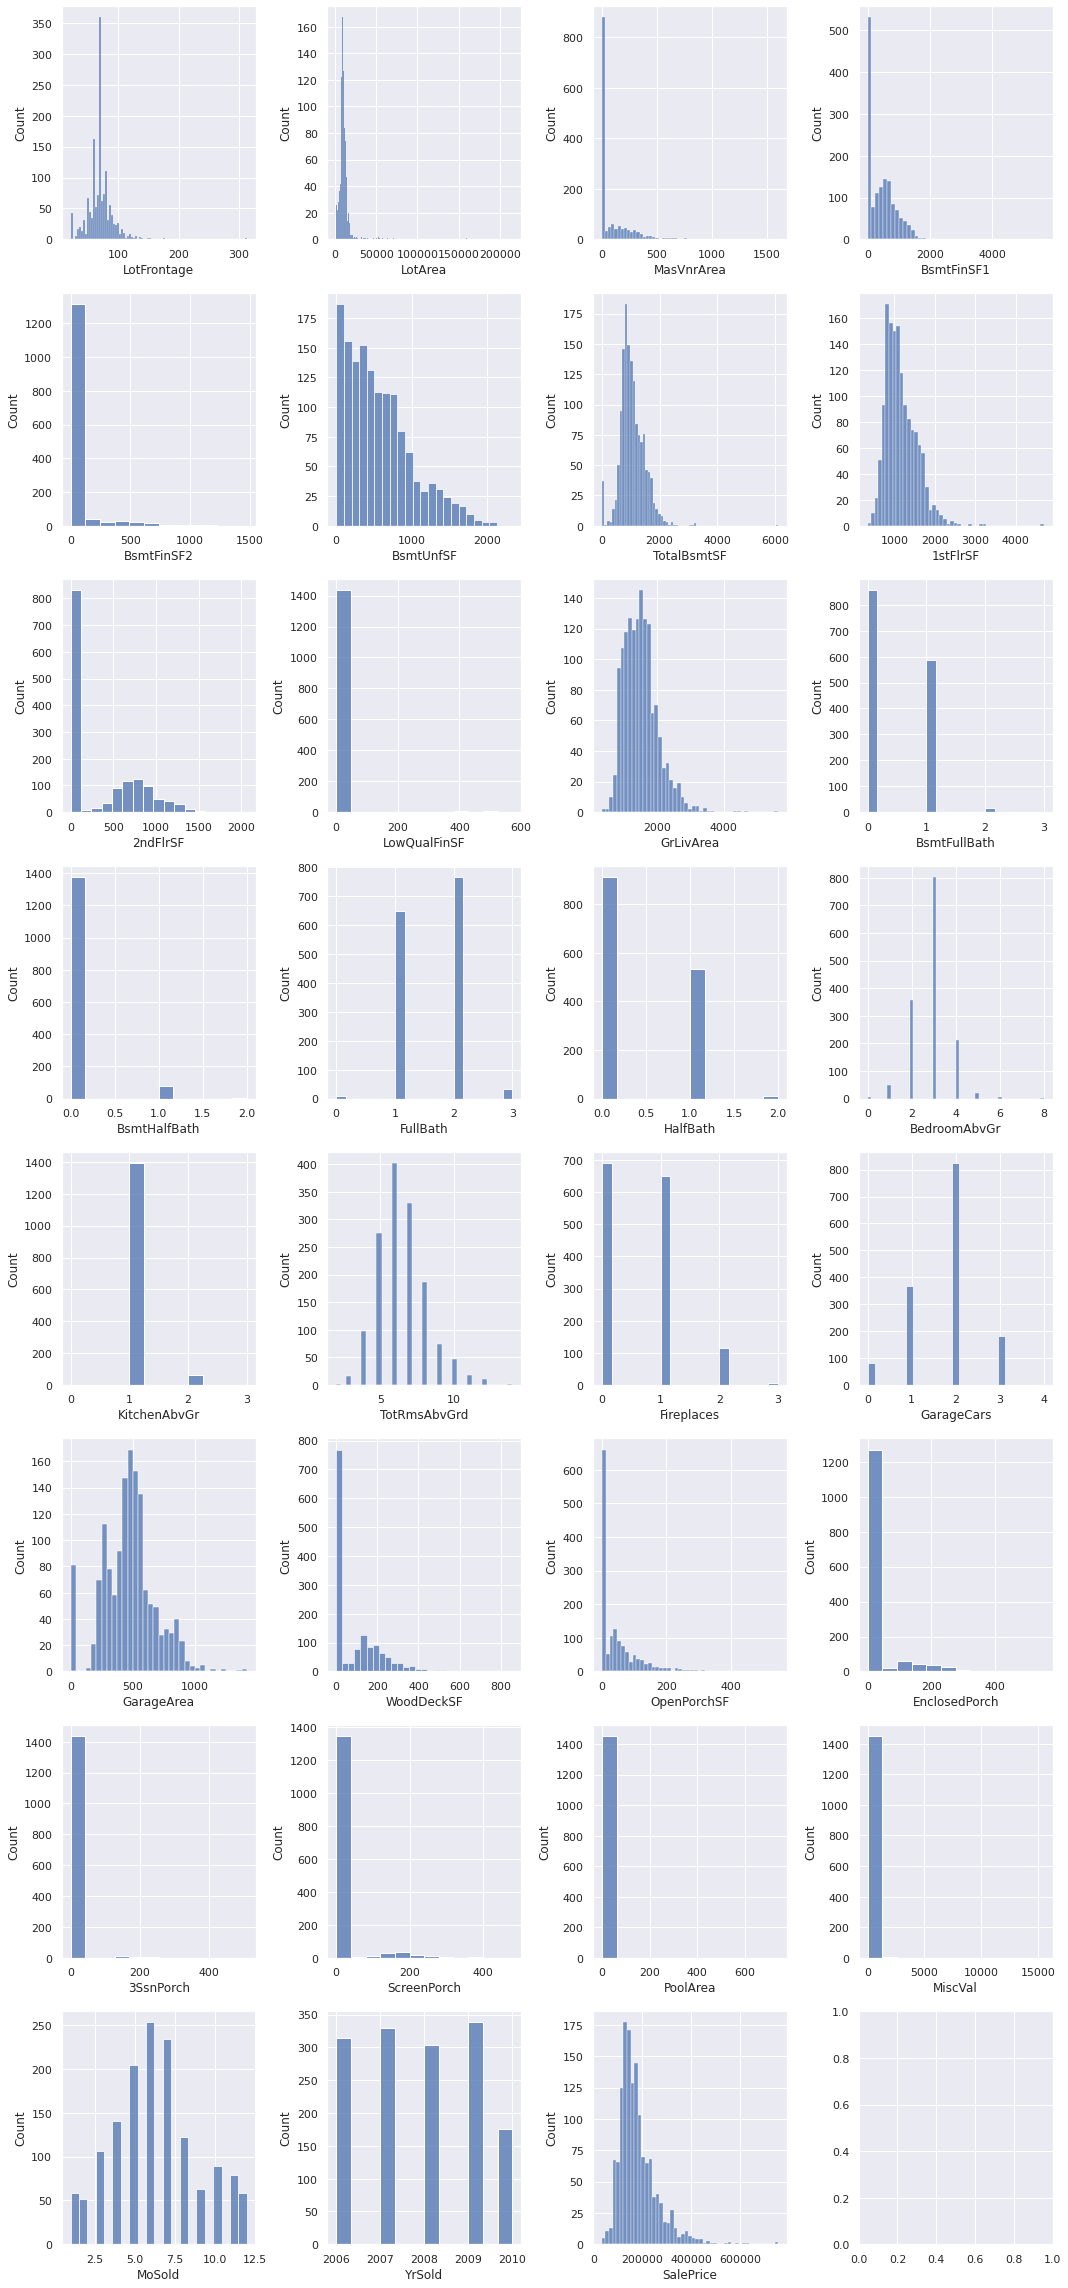

In [ ]:
idx = 1
fig, axs = plt.subplots(8,4, figsize=(15,32))
for i in range(8):
    for j in range(4):
        if len(numerical_quintatif_cols) > idx:
            sns.histplot(x = data_train[numerical_quintatif_cols[idx]], ax=axs[i][j])
            idx += 1
plt.tight_layout()
plt.show()

In [ ]:
data_train[numerical_quintatif_cols[1:]].skew()

LotFrontage       2.402352
LotArea          12.207688
MasVnrArea        2.676546
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
SalePrice         1.882876
dtype: float64

In [ ]:
treshold_skew = 2
pd_check_skew = data_train[numerical_quintatif_cols[1:]].skew()
pd_check_skew[pd_check_skew < treshold_skew].index

Index(['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
print('Before Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

data_train_encode.drop(columns=pd_check_skew[pd_check_skew > treshold_skew].index, inplace=True)
data_test_encode.drop(columns=pd_check_skew[pd_check_skew > treshold_skew].index, inplace=True)

print('\nAfter Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

Before Delete Feature
Data train (1460, 77)
Data test (1459, 77) 


After Delete Feature
Data train (1460, 64)
Data test (1459, 64) 



In [ ]:
for column in pd_check_skew[pd_check_skew > treshold_skew].index:
    numerical_quintatif_cols.remove(column)

print(numerical_quintatif_cols)

['Id', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'MoSold', 'YrSold', 'SalePrice']


In [ ]:
treshold_corr = 0.3
corr = data_train_encode[numerical_quintatif_cols].corr()['SalePrice']
corr[corr < treshold_corr].index

Index(['Id', 'BsmtUnfSF', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'MoSold',
       'YrSold'],
      dtype='object')

In [ ]:
print('Before Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

data_train_encode.drop(columns=corr[corr < treshold_corr].index, inplace=True)
data_test_encode.drop(columns=corr[corr < treshold_corr].index, inplace=True)

print('\nAfter Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

Before Delete Feature
Data train (1460, 64)
Data test (1459, 64) 


After Delete Feature
Data train (1460, 57)
Data test (1459, 57) 



In [ ]:
for column in corr[corr < treshold_corr].index:
    numerical_quintatif_cols.remove(column)

print(numerical_quintatif_cols)

['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'SalePrice']


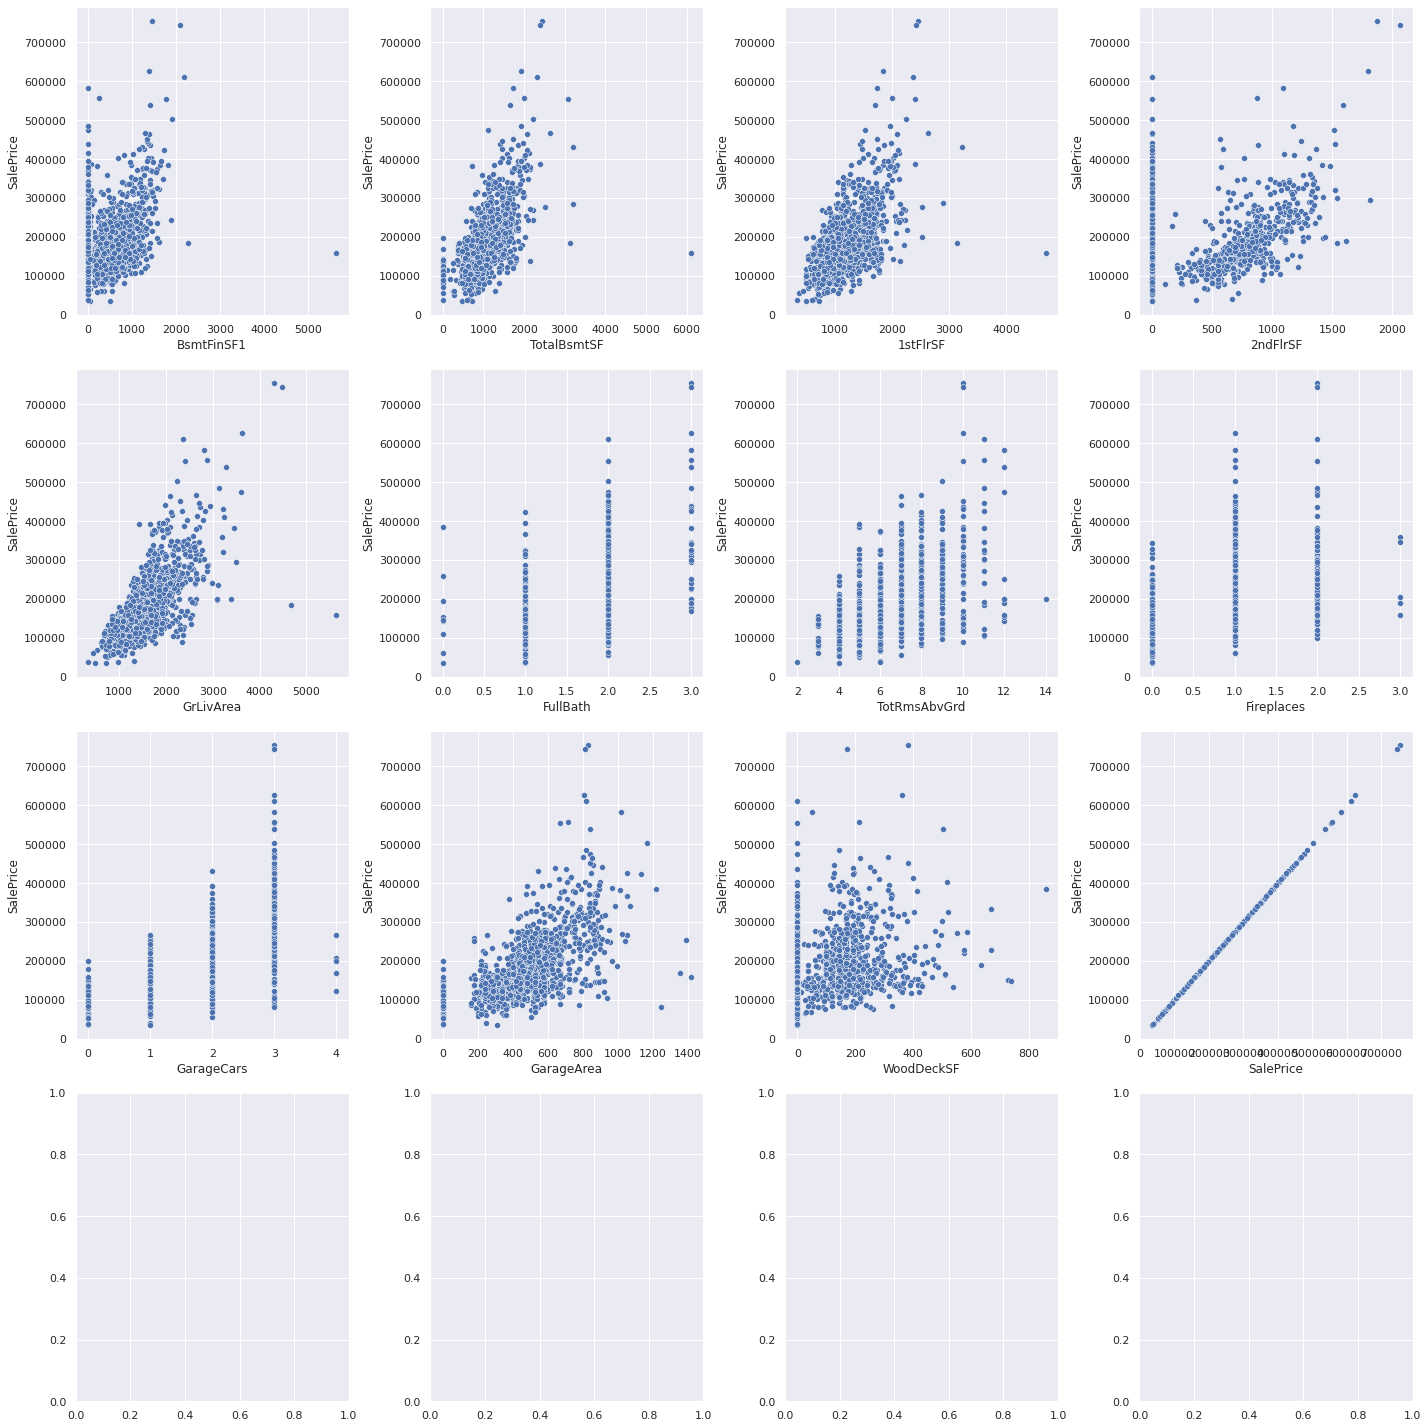

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
idx = 0
for  i in range(4):
    for j in range(4):
        if idx < len(numerical_quintatif_cols):
            sns.scatterplot(x=numerical_quintatif_cols[idx], y='SalePrice', data=data_train_encode, ax = axs[i][j])
            idx += 1

plt.tight_layout()
plt.show()

In [ ]:
numerical_quintatif_cols

['BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'SalePrice']

In [ ]:
numerical_quintatif_cols
del_cols = []#['ScreenPorch','OpenPorchSF','WoodDeckSF','BsmtUnfSF','BsmtFinSF1', 'MasVnrArea', 'LotFrontage']
print('Before Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

data_train_encode.drop(columns=del_cols, inplace=True)
data_test_encode.drop(columns=del_cols, inplace=True)


print('\nAfter Delete Feature')
print('Data train',data_train_encode.shape)
print('Data test',data_test_encode.shape,'\n')

Before Delete Feature
Data train (1460, 57)
Data test (1459, 57) 


After Delete Feature
Data train (1460, 57)
Data test (1459, 57) 



In [ ]:
for column in del_cols:
    if column in numerical_quintatif_cols:
        numerical_quintatif_cols.remove(column)
    
print(numerical_quintatif_cols)

['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'SalePrice']


In [ ]:
print(data_train_encode.shape)

(1460, 57)


In [ ]:
print("I will remove some row outliers based of numerical columns")
numerical_cols = numerical_quintatif_cols
numerical_cols.insert(0, 'SalePrice')
data_train_filter_outlier = data_train_encode.copy()
for columns in numerical_cols:
    sp = data_train_filter_outlier[columns]
    Q1 = sp.quantile(q=0.25)
    Q3 = sp.quantile(q=0.75)
    IQR = Q3 - Q1
    min_sp = Q1 - (IQR * 1.5)
    max_sp = Q3 + (IQR * 1.5)

    data_train_filter_outlier = data_train_filter_outlier[sp.between(min_sp, max_sp)]

print('Before Filter', data_train_encode.shape)
print('After Filter',data_train_filter_outlier.shape)

I will remove some row outliers based of numerical columns
Before Filter (1460, 57)
After Filter (1235, 57)


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [ ]:
all_dataset = pd.concat((data_train_filter_outlier, data_test_encode),axis=0)
all_dataset.shape

(2694, 57)

In [ ]:
nominal_cols = []
other_cols = []
for column in all_dataset.columns.values:
    if column in categorical_nominal_cols or column in categorical_bool_cols:
        nominal_cols.append(column)
    else:
        other_cols.append(column)

print('nominal_cols', len(nominal_cols))
print('other_cols', len(other_cols))

nominal_cols 26
other_cols 31


In [ ]:
onehot = OneHotEncoder()
scaler = StandardScaler()

pd_all_data = pd.concat((data_train_filter_outlier, data_test_encode), axis=0)

onehot.fit(pd_all_data[nominal_cols])
scaler.fit(pd_all_data[other_cols])

StandardScaler()

In [ ]:
def getSelectedData(pd_data, nominal_cols, other_cols):
    nominal_col_feature = onehot.transform(pd_data[nominal_cols]).toarray()
    other_col_feature = scaler.transform(pd_data[other_cols])
    x = np.concatenate((nominal_col_feature,  other_col_feature[:,:-1]),axis=1)
    y = other_col_feature[:,-1]
    return x, y, nominal_col_feature, other_col_feature

In [ ]:
x_train, y_train, _, _ = getSelectedData(data_train_filter_outlier, nominal_cols, other_cols)
print('x_train',x_train.shape)
print('y_train',y_train.shape)

x_train (1235, 227)
y_train (1235,)


In [ ]:
x_train_ = sm.add_constant(x_train)
ols = sm.OLS(y_train, x_train_).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     64.98
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:06   Log-Likelihood:                 502.16
No. Observations:                1235   AIC:                            -628.3
Df Residuals:                    1047   BIC:                             334.0
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0741      0.032      2.343      0.019       0.012       0.136
x1             0.1234      0.061      2.024      0.043       0.004       0.243
x2             0.0742      0.049      1.518      0.129      -0.022       0.170
x3             0.1705      0.060      2.864      0.004       0.054       0.287
x4             0.1228      0.069      1.776      0.076      -0.013       0.258
x5            -0.0699      0.184     -0.381      0.704      -0.430       0.291
x6            -0.0164      0.165     -0.100      0.921      -0.340       0.307
x7            -0.0753      0.029     -2.557      0.011      -0.133      -0.018
x8            -0.0920      0.097     -0.945      0.345      -0.283       0.099
x9             0.0813      0.057      1.431      0.153      -0.030       0.193
x10           -0.0450      0.082     -0.547      0.585      -0.207       0.117
x11           -0.0805      0.090     -0.897      0.370      -0.257       0.096
x12           -0.2383      0.111     -2.150      0.032      -0.456      -0.021
x13            0.3514      0.155      2.268      0.024       0.047       0.655
x14           -0.1930      0.129     -1.500      0.134      -0.446       0.060
x15           -0.0390      0.116     -0.336      0.737      -0.267       0.189
x16        -1.511e-17   6.23e-16     -0.024      0.981   -1.24e-15    1.21e-15
x17            0.1462      0.027      5.378      0.000       0.093       0.200
x18            0.0018      0.030      0.061      0.952      -0.056       0.060
x19           -0.3059      0.067     -4.573      0.000      -0.437      -0.175
x20            0.1679      0.051      3.297      0.001       0.068       0.268
x21            0.0640      0.052      1.240      0.215      -0.037       0.165
x22         7.284e-16   5.73e-16      1.270      0.204   -3.97e-16    1.85e-15
x23            0.0724      0.060      1.216      0.224      -0.044       0.189
x24            0.0017      0.070      0.024      0.981      -0.135       0.139
x25           -0.0143      0.023     -0.621      0.535      -0.059       0.031
x26           -0.0248      0.022     -1.129      0.259      -0.068       0.018
x27            0.0358      0.032      1.105      0.269      -0.028       0.099
x28            0.0774      0.054      1.438      0.151      -0.028       0.183
x29           -0.0040      0.022     -0.187      0.851      -0.046       0.038
x30         2.151e-05      0.028      0.001      0.999      -0.054       0.054
x31            0.0842      0.038      2.192      0.029       0.009       0.160
x32           -0.0061      0.030     -0.207      0.836      -0.064       0.052
x33            0.2519      0.102      2.481      0.013       0.053       0.451
x34           -0.1778      0.118     -1.503      0.133      -0.410       0.054
x35        -4.497e-16   4.61e-16     -0.975      0.330   -1.35e-15    4.55e-16
x3

In [ ]:
x_test, _, _, numerical_feature = getSelectedData(data_test_encode, nominal_cols, other_cols)
print('x_test',x_test.shape)
print('numerical_feature',numerical_feature.shape)

x_test (1459, 227)
numerical_feature (1459, 31)


In [ ]:
x_test_ = sm.add_constant(x_test)
y_test_pred = ols.predict(x_test_)
print(y_test_pred.shape)
print(numerical_feature[:,-1])

(1459,)
[-0.84821697 -0.84821697 -0.84821697 ... -0.84821697 -0.84821697
 -0.84821697]


In [ ]:
numerical_feature[:,-1] = y_test_pred
inverse_numerical_feature = scaler.inverse_transform(numerical_feature)
data_test_predict = data_test.copy()
data_test_predict['SalePrice'] = np.round(inverse_numerical_feature[:,-1],2)

In [ ]:
data_test_predict.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Gd,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,108585.36
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Gd,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,165544.41
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,185351.07
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,199363.06
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Gd,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,188849.18


In [ ]:
submission = data_test_predict[['Id', 'SalePrice']]
submission.to_csv('./submission.csv', index=False)